In [156]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras

In [2]:
# Read data from csv file, consider column 'date' as index and parse it into date object
dataset = pd.read_csv('../input/historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [3]:
# Selecting training_set from begining of 2015 till end of 2017, we can do this because our index in date object
# and selecting test_set from begining of 2018 onwards
trainSet = dataset['2015':'2017'].sort_values(by=['ticker','date'])
testSet = dataset['2018':].sort_values(by=['ticker','date'])

# Normalize every samples independently

In [283]:
timesteps = 60
x_train = []
y_train = []
for s in symbols:
    train_stock = trainSet.loc[trainSet['ticker'] == s][['adj_close']].values
    for i in range(timesteps, len(train_stock)):
        x = train_stock[i-timesteps: i, 0]
        y = train_stock[i,0]
        x = x.reshape(-1,1)
        y = y.reshape(-1,1)
        
        sc = MinMaxScaler(feature_range=(0,1))
        sc.partial_fit(x)
        sc.partial_fit(y)
        x_scaled = sc.transform(x)
        y_scaled = sc.transform(y)
        
        x_train.append(x_scaled)
        y_train.append(y_scaled)
    if s== 'AAPL':
        break
X_train0, Y_train0 = np.array(x_train), np.array(y_train)
Y_train0 = Y_train0.reshape(Y_train0.shape[0],1)

In [160]:
X_train0.shape, Y_train0.shape

((6890, 60, 1), (6890, 1))

# Normalize each symbols independently

In [327]:
scaler1 = {}
timesteps = 60
x_train = []
y_train = []
test_set1 = {}
for s in symbols:
    # Selecting adj_close values
    train_stock = trainSet.loc[trainSet['ticker'] == s][['adj_close']].values
    test_stock = testSet.loc[testSet['ticker'] == s][['adj_close']].values
    # Normalize values
    sc = MinMaxScaler(feature_range=(0,1))
    sc.partial_fit(train_stock)
    sc.partial_fit(test_stock)
    train_scaled = sc.transform(train_stock)
    scaler1[s] = sc
    
    # Define training data
    for i in range(timesteps, len(train_scaled)):
        x_train.append(train_scaled[i-timesteps: i, 0])
        y_train.append(train_scaled[i, 0])
    
    # Define test data
    test_scaled = sc.transform(test_stock)
    x_test = []
    y_test = []
    for i in range(timesteps, len(test_scaled)):
        x_test.append(test_scaled[i-timesteps: i, 0])
        y_test.append(test_scaled[i, 0])
    X_test, Y_test = np.array(x_test), np.array(y_test)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    test_set1[s] = {}
    test_set1[s]['X_test'] = X_test
    test_set1[s]['Y_test'] = Y_test
    
    if s == 'AAPL':
        break
X_train1, Y_train1 = np.array(x_train), np.array(y_train)
X_train1 = X_train1.reshape(X_train1.shape[0], X_train1.shape[1], 1)

In [163]:
# Callback function `earlystopping` to trigger while training it monitor 'loss'
# start from first epoch it record min value of loss and if model can not find 
# lower loss value in next 3 epochs model will stop training.
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3, mode='min')

In [188]:
# The GRU architecture
# We are using Sequential model of Keras
# Our hidden layer using activation = 'tanh' and having 50 neurons each layer
# The output layer of fully connected layer is having only 1 neurons because we want only one output value

regressorGRU0 = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU0.add(GRU(units=50, return_sequences=True, input_shape=(60,1), activation='tanh'))
regressorGRU0.add(Dropout(0.2))
# Second GRU layer
regressorGRU0.add(GRU(units=50, return_sequences=True, input_shape=(60,1), activation='tanh'))
regressorGRU0.add(Dropout(0.2))
# Third GRU layer
regressorGRU0.add(GRU(units=50, return_sequences=True, input_shape=(60,1), activation='tanh'))
regressorGRU0.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU0.add(GRU(units=50, activation='tanh'))
regressorGRU0.add(Dropout(0.2))
# The output layer
regressorGRU0.add(Dense(units=1))

In [189]:
# Compiling the model
regressorGRU0.compile(optimizer='rmsprop', loss='mean_squared_error')

# Training on X_train0 Y_train0 #

In [190]:
n_epoch = 50
regressorGRU0.fit(X_train0, 
                 Y_train0,
                 epochs = n_epoch, 
                 batch_size = len(Y_train0) // n_epoch, 
                 validation_split = 0.2,callbacks=[es])

Train on 5512 samples, validate on 1378 samples
Epoch 1/50
5512/5512 [==============================] - 21s 4ms/step - loss: 0.0696 - val_loss: 0.0387
Epoch 2/50
5512/5512 [==============================] - 17s 3ms/step - loss: 0.0430 - val_loss: 0.0229
Epoch 3/50
5512/5512 [==============================] - 17s 3ms/step - loss: 0.0354 - val_loss: 0.0290
Epoch 4/50
5512/5512 [==============================] - 17s 3ms/step - loss: 0.0315 - val_loss: 0.0183
Epoch 5/50
5512/5512 [==============================] - 17s 3ms/step - loss: 0.0272 - val_loss: 0.0265
Epoch 6/50
5512/5512 [==============================] - 17s 3ms/step - loss: 0.0257 - val_loss: 0.0173
Epoch 7/50
5512/5512 [==============================] - 17s 3ms/step - loss: 0.0230 - val_loss: 0.0146
Epoch 8/50
5512/5512 [==============================] - 17s 3ms/step - loss: 0.0226 - val_loss: 0.0132
Epoch 9/50
5512/5512 [==============================] - 17s 3ms/step - loss: 0.0221 - val_loss: 0.0162
Epoch 10/50
5512/5512 [==

In [191]:
# The GRU architecture
# We are using Sequential model of Keras
# Our hidden layer using activation = 'tanh' and having 50 neurons each layer
# The output layer of fully connected layer is having only 1 neurons because we want only one output value

regressorGRU1 = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU1.add(GRU(units=50, return_sequences=True, input_shape=(60,1), activation='tanh'))
regressorGRU1.add(Dropout(0.2))
# Second GRU layer
regressorGRU1.add(GRU(units=50, return_sequences=True, input_shape=(60,1), activation='tanh'))
regressorGRU1.add(Dropout(0.2))
# Third GRU layer
regressorGRU1.add(GRU(units=50, return_sequences=True, input_shape=(60,1), activation='tanh'))
regressorGRU1.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU1.add(GRU(units=50, activation='tanh'))
regressorGRU1.add(Dropout(0.2))
# The output layer
regressorGRU1.add(Dense(units=1))

In [192]:
# Compiling the model
regressorGRU1.compile(optimizer='rmsprop', loss='mean_squared_error')

# Training on X_train1 Y_train1 #

In [193]:
n_epoch = 50
regressorGRU1.fit(X_train1, 
                 Y_train1,
                 epochs = n_epoch, 
                 batch_size = len(Y_train1) // n_epoch, 
                 validation_split = 0.2,callbacks=[es])

Train on 5512 samples, validate on 1378 samples
Epoch 1/50
5512/5512 [==============================] - 22s 4ms/step - loss: 0.0153 - val_loss: 0.0030
Epoch 2/50
5512/5512 [==============================] - 17s 3ms/step - loss: 0.0078 - val_loss: 0.0027
Epoch 3/50
5512/5512 [==============================] - 17s 3ms/step - loss: 0.0068 - val_loss: 0.0015
Epoch 4/50
5512/5512 [==============================] - 17s 3ms/step - loss: 0.0061 - val_loss: 0.0121
Epoch 5/50
5512/5512 [==============================] - 17s 3ms/step - loss: 0.0055 - val_loss: 0.0037
Epoch 6/50
5512/5512 [==============================] - 17s 3ms/step - loss: 0.0053 - val_loss: 0.0012
Epoch 7/50
5512/5512 [==============================] - 17s 3ms/step - loss: 0.0045 - val_loss: 9.5145e-04
Epoch 8/50
5512/5512 [==============================] - 17s 3ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 9/50
5512/5512 [==============================] - 17s 3ms/step - loss: 0.0043 - val_loss: 0.0102
Epoch 10/50
5512/5512

## Helper function ##

In [194]:
# Calculate Mean squared_error #
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    return mse

In [195]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker, des):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {} on {}'.format(ticker, des))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

# Evaluate regressorGRU0 #

In [318]:
# Preparing test data
scaler0 = {}
test_set0 = {}

for s in symbols:
    test_stock = testSet.loc[testSet['ticker'] == s][['adj_close']].values
    test_set0[s] = {}
    scaler0[s] = []
    x_test = []
    y_test = []
    for i in range(timesteps, len(test_stock)):
        x = test_stock[i-timesteps: i, 0]
        y = test_stock[i,0]
        x = x.reshape(-1,1)
        y = y.reshape(-1,1)

        sc = MinMaxScaler(feature_range=(0,1))
        sc.partial_fit(x)
        sc.partial_fit(y)
        x_scaled = sc.transform(x)
        scaler0[s].append(sc)

        x_test.append(x_scaled)
        y_test.append(y)
    X_test, Y_test = np.array(x_test), np.array(y_test)
    Y_test = Y_test.reshape(Y_test.shape[0],1)

    test_set0[s]['X_test'] = X_test
    test_set0[s]['Y_test'] = Y_test
    
    if s == 'AAPL':
        break

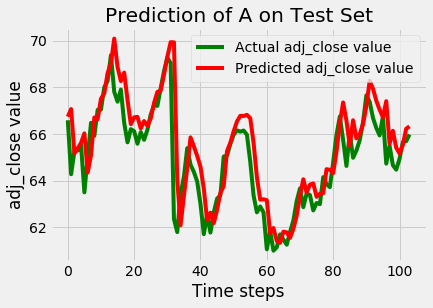

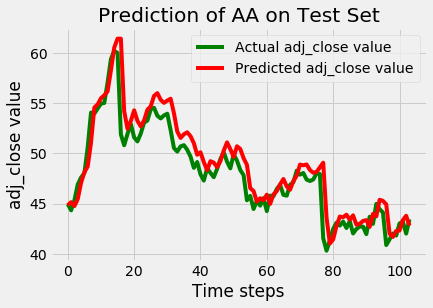

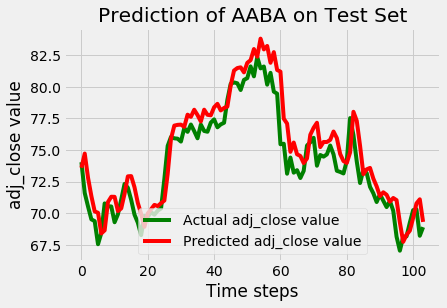

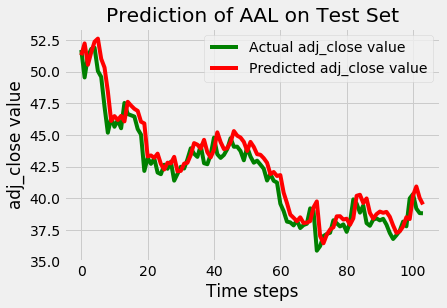

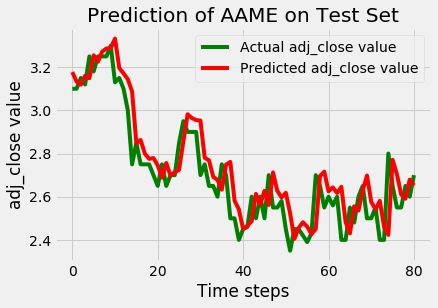

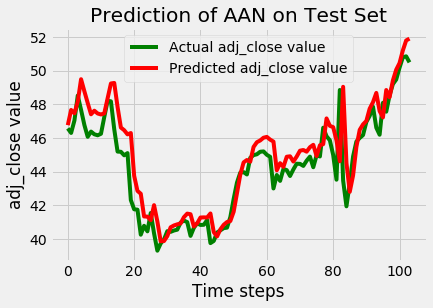

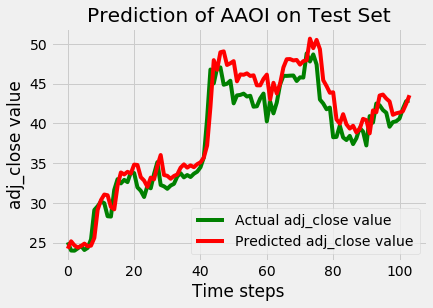

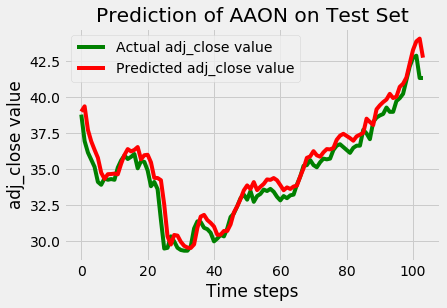

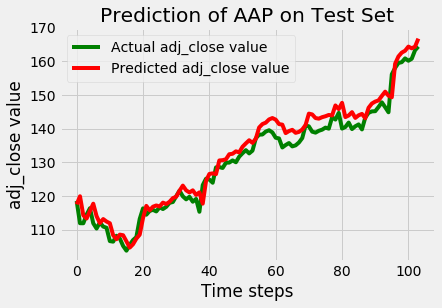

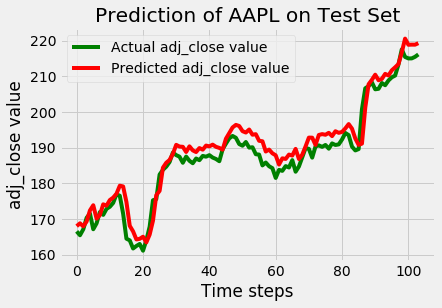

In [324]:
# Evaluate model
mse_val = {}
for s in test_set0:
    X_test = test_set0[s]['X_test']
    Y_test = test_set0[s]['Y_test']
    result = regressorGRU0.predict(X_test)

    y_pred = []
    for i in range(0,len(result)):
        y = result[i]
        y = y.reshape(-1,1)
        k = scaler0[s][i].inverse_transform(y)
        y_pred.append(k[0][0])
        
    plotting_graph(Y_test,y_pred, s, 'Test Set')
    mse_val[s] = return_mse(Y_test, y_pred)
    

In [326]:
for s in mse_val:
    print('MSE of {}: {}'.format(s, mse_val[s]))

MSE of A: 1.6046315222072551
MSE of AA: 3.4141260760721965
MSE of AABA: 2.7013645333186433
MSE of AAL: 1.3976396808755978
MSE of AAME: 0.013907018044734125
MSE of AAN: 1.7737946698448708
MSE of AAOI: 4.817676245280902
MSE of AAON: 0.8019937818804649
MSE of AAP: 10.156731125974138
MSE of AAPL: 12.541093954993645


# Evaluate regressorGRU1 #

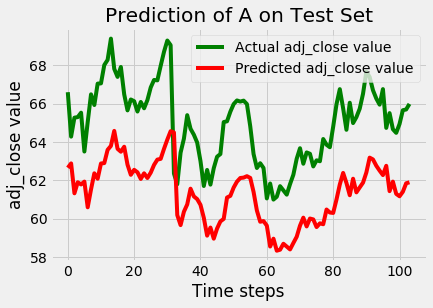

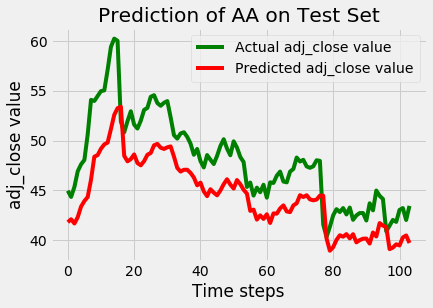

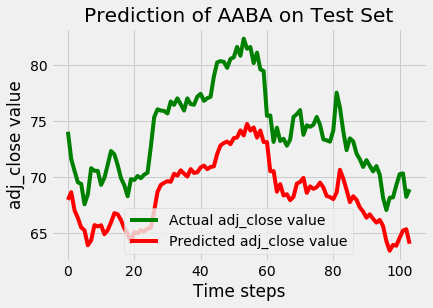

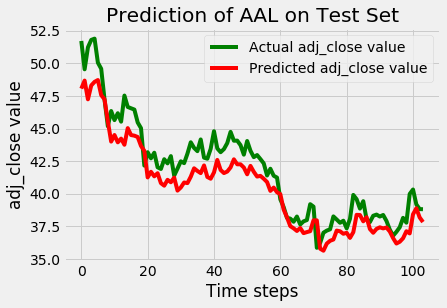

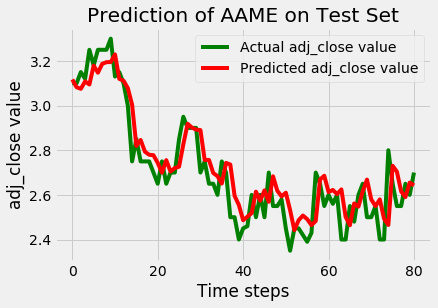

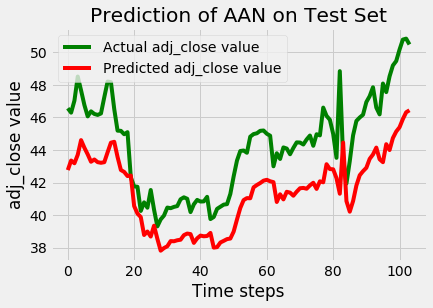

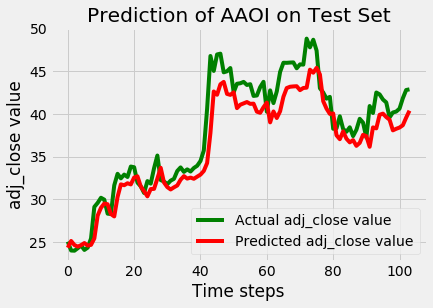

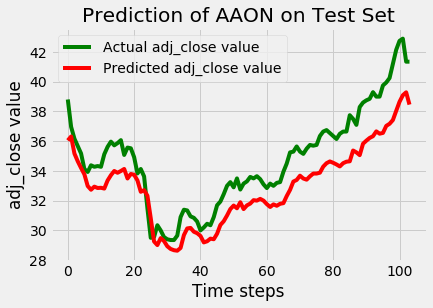

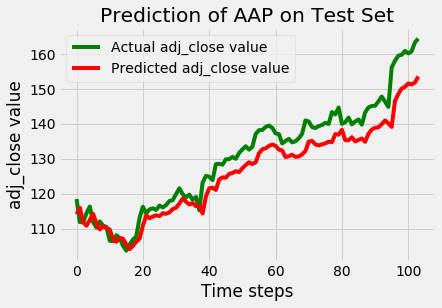

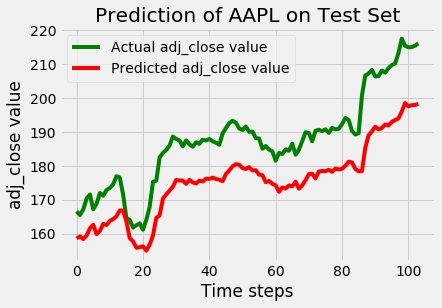

In [331]:
mse_val = {}
for s in symbols:
    sc = scaler1[s]
    y_test = test_set1[s]['Y_test'].reshape(-1,1)
    y_true = sc.inverse_transform(y_test)
    X_test = test_set1[s]['X_test']
    result = regressorGRU.predict(X_test)
    y_pred = sc.inverse_transform(result)
    
    plotting_graph(y_true,y_pred, s, 'Test Set')
    mse_val[s] = return_mse(y_true, y_pred)
    if s == 'AAPL':
        break

In [332]:
for s in mse_val:
    print('MSE of {}: {}'.format(s, mse_val[s]))

MSE of A: 13.980816746624898
MSE of AA: 14.566738260633294
MSE of AABA: 31.914476719742844
MSE of AAL: 2.6833204162252833
MSE of AAME: 0.011217332411574832
MSE of AAN: 9.2455234771517
MSE of AAOI: 5.986690690325432
MSE of AAON: 3.7730290792396057
MSE of AAP: 31.160358723698444
MSE of AAPL: 156.6905657749567
